## Paso 1: Subida de datos

In [2]:
%%capture
!pip install kaggle

In [3]:
from google.colab import files

print("Sube tu archivo kaggle.json (lo descargas desde tu cuenta de Kaggle).")
uploaded = files.upload()

Sube tu archivo kaggle.json (lo descargas desde tu cuenta de Kaggle).


Saving archive.zip to archive.zip


In [4]:
import os

# Carpeta donde dejaremos el dataset descomprimido
base_dir = "data/fer2013"
os.makedirs(base_dir, exist_ok=True)

# Descomprimir el archivo archive.zip dentro de data/fer2013
!unzip -q archive.zip -d {base_dir}

print("Contenido de data/fer2013:")
!ls {base_dir}

Contenido de data/fer2013:
archive  __MACOSX


In [5]:
!ls data/fer2013/archive

test  train


In [6]:
from pathlib import Path

data_root = Path("data/fer2013/archive")
train_dir = data_root / "train"
test_dir  = data_root / "test"

print("Train dir:", train_dir, "->", train_dir.exists())
print("Test dir :", test_dir,  "->", test_dir.exists())

print("\nClases en train:")
print([d.name for d in train_dir.iterdir() if d.is_dir()])

Train dir: data/fer2013/archive/train -> True
Test dir : data/fer2013/archive/test -> True

Clases en train:
['angry', 'surprise', 'disgust', 'happy', 'fear', 'sad', 'neutral']


## Paso 2

In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [8]:
# Transforms para el conjunto de entrenamiento
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),   # Asegura 3 canales
    transforms.Resize((224, 224)),                 # Tamaño que usa VGG16
    transforms.ToTensor(),                         # [0,255] -> [0,1] tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],                # ImageNet
        std=[0.229, 0.224, 0.225]
    )
])

# Transforms para el conjunto de prueba (sin augmentación)
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [9]:
data_root = Path("data/fer2013/archive")
train_dir = data_root / "train"
test_dir  = data_root / "test"

train_dataset = datasets.ImageFolder(root=str(train_dir), transform=train_transform)
test_dataset  = datasets.ImageFolder(root=str(test_dir),  transform=test_transform)

print("Número de imágenes en train:", len(train_dataset))
print("Número de imágenes en test :", len(test_dataset))
print("Clases (orden de índices):", train_dataset.classes)


Número de imágenes en train: 28709
Número de imágenes en test : 7178
Clases (orden de índices): ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [10]:
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,      # Mezcla los ejemplos en cada época
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False      # En test no hace falta mezclar
)

print("Batches en train_loader:", len(train_loader))
print("Batches en test_loader :", len(test_loader))


Batches en train_loader: 449
Batches en test_loader : 113


In [11]:
images, labels = next(iter(train_loader))
print("Shape del batch de imágenes:", images.shape)
print("Shape del batch de labels  :", labels.shape)

# Debe mostrar algo como:
# Shape del batch de imágenes: torch.Size([64, 3, 224, 224])
# Shape del batch de labels  : torch.Size([64])

Shape del batch de imágenes: torch.Size([64, 3, 224, 224])
Shape del batch de labels  : torch.Size([64])


## Paso 3

In [12]:
from torchvision import models
from torchvision.models import VGG16_Weights

# 1. Cargar los pesos preentrenados de ImageNet
weights = VGG16_Weights.IMAGENET1K_V1

# 2. Cargar el modelo VGG16 con esos pesos
model = models.vgg16(weights=weights)

# 3. Enviar el modelo al dispositivo que definimos antes (GPU si hay)
model = model.to(device)

print(type(model))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 71.8MB/s]


<class 'torchvision.models.vgg.VGG'>


In [13]:
print(model.classifier)


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [14]:
# Número de clases en nuestro problema
num_classes = 7

# Obtener cuántas entradas tiene la última capa
in_features = model.classifier[6].in_features
print("in_features de la última capa:", in_features)

# Reemplazar la última capa por una nueva: 4096 -> 7
model.classifier[6] = nn.Linear(in_features, num_classes)

# Enviar de nuevo la parte modificada al device (por si acaso)
model = model.to(device)

print(model.classifier)


in_features de la última capa: 4096
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=7, bias=True)
)


In [15]:
# Congelar TODAS las capas convolucionales (features)
for param in model.features.parameters():
    param.requires_grad = False

In [16]:
import torch.optim as optim

# Función de pérdida para clasificación multiclase
criterion = nn.CrossEntropyLoss()

# Solo entrenamos los parámetros con requires_grad=True
trainable_params = [p for p in model.parameters() if p.requires_grad]

print("Número de parámetros entrenables:", sum(p.numel() for p in trainable_params))

# Optimizador (puedes ajustar el lr si luego ves que converge lento)
optimizer = optim.Adam(trainable_params, lr=1e-4)


Número de parámetros entrenables: 119574535


## Paso 4

In [17]:
num_epochs = 5

for epoch in range(num_epochs):
    # ------ FASE DE ENTRENAMIENTO ------
    model.train()  # pone el modelo en modo entrenamiento

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Enviar batch a CPU/GPU
        images = images.to(device)
        labels = labels.to(device)

        # 1. Resetear gradientes acumulados
        optimizer.zero_grad()

        # 2. Paso hacia adelante (forward)
        outputs = model(images)          # shape: [batch, 7]

        # 3. Calcular pérdida
        loss = criterion(outputs, labels)

        # 4. Backpropagation
        loss.backward()

        # 5. Actualizar pesos (solo los entrenables)
        optimizer.step()

        # Acumular estadísticas de entrenamiento
        running_loss += loss.item() * images.size(0)

        # Predicciones: índice de la clase con mayor logit
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # ------ FASE DE EVALUACIÓN EN TEST ------
    model.eval()   # modo evaluación (sin dropout, etc.)
    test_correct = 0
    test_total = 0

    with torch.no_grad():  # sin gradientes
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total

    print(f"Época [{epoch+1}/{num_epochs}] "
          f"- Train Loss: {epoch_loss:.4f} "
          f"- Train Acc: {epoch_acc:.4f} "
          f"- Test Acc: {test_acc:.4f}")

Época [1/5] - Train Loss: 1.3766 - Train Acc: 0.4773 - Test Acc: 0.5475
Época [2/5] - Train Loss: 1.0500 - Train Acc: 0.6102 - Test Acc: 0.5826
Época [3/5] - Train Loss: 0.7682 - Train Acc: 0.7211 - Test Acc: 0.6067
Época [4/5] - Train Loss: 0.4734 - Train Acc: 0.8344 - Test Acc: 0.6133
Época [5/5] - Train Loss: 0.2725 - Train Acc: 0.9066 - Test Acc: 0.5977


La pérdida de entrenamiento disminuyó de 1.38 a 0.27 y la exactitud en entrenamiento aumentó de 47.7 % a 90.7 %. La exactitud en el conjunto de prueba se estabilizó alrededor de 60 %, alcanzando un máximo de 61.3 % en la cuarta época, lo que indica un compromiso razonable entre aprendizaje y generalización, con signos de sobreajuste en la última época.

## Paso 5: Evaluacion

In [20]:
import torch

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.append(predicted.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

test_acc = (all_preds == all_labels).float().mean().item()
print(f"Accuracy final en test: {test_acc:.4f}")


Accuracy final en test: 0.5977


Clases (orden): ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Shape cm: (7, 7)


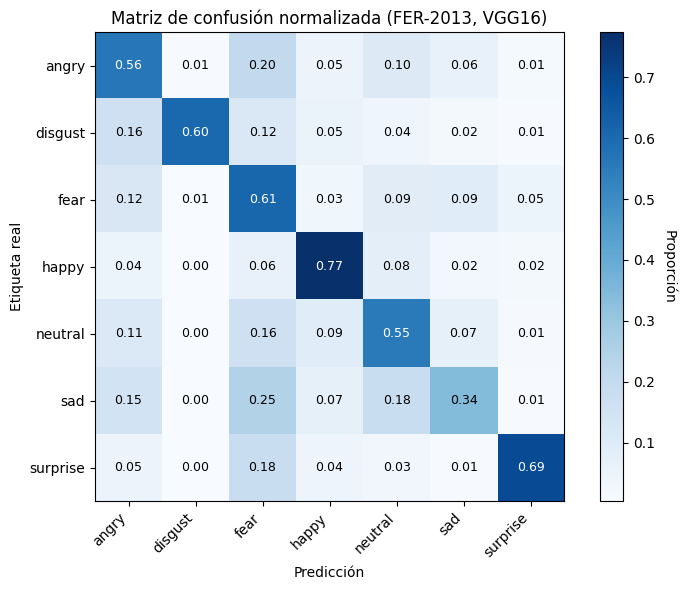

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Clases y número de clases
classes = train_dataset.classes
num_classes = len(classes)
print("Clases (orden):", classes)

# 2. Matriz de confusión (filas: real, columnas: predicho)
cm = confusion_matrix(all_labels, all_preds)
print("Shape cm:", cm.shape)

# 3. Normalizar por fila (opcional, para ver proporciones)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(8, 6))

im = ax.imshow(cm_norm, interpolation="nearest", cmap=plt.cm.Blues)
cbar = plt.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Proporción", rotation=270, labelpad=15)

# 4. Ticks y etiquetas
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)

ax.set_xlabel("Predicción")
ax.set_ylabel("Etiqueta real")
ax.set_title("Matriz de confusión normalizada (FER-2013, VGG16)")

# 5. Escribir los valores dentro de cada celda
thresh = cm_norm.max() / 2.0
for i in range(num_classes):
    for j in range(num_classes):
        value = cm_norm[i, j]
        text_color = "white" if value > thresh else "black"
        ax.text(
            j, i,
            f"{value:.2f}",
            ha="center",
            va="center",
            color=text_color,
            fontsize=9
        )

plt.tight_layout()
plt.show()

La matriz de confusión revela que el modelo acierta con mayor frecuencia en las clases happy y neutral, mientras que presenta mayores errores en la distinción entre sad y neutral y entre fear y surprise. Esto sugiere que las expresiones de estas clases son más difíciles de separar solo a partir de la información visual disponible en FER-2013.

In [23]:
torch.save(model.state_dict(), "vgg16_fer2013.pth")
print("Modelo guardado en vgg16_fer2013.pth")

Modelo guardado en vgg16_fer2013.pth


# Pregunta de Reflexion

**¿Cuál es la principal ventaja de utilizar el modelo VGG16 pre-entrenado en esta tarea?**

La principal ventaja es que VGG16 ya ha aprendido características visuales generales al ser entrenado previamente en un dataset muy grande como ImageNet (millones de imágenes y 1000 clases). Al reutilizar esas capas convolucionales pre-entrenadas como extractor de características, no necesito aprender desde cero filtros para bordes, texturas, formas faciales, etc., sino solo ajustar la parte final del modelo a mi problema específico (las 7 emociones). Esto reduce mucho la cantidad de datos y tiempo de entrenamiento necesarios, mejora la capacidad de generalización frente a entrenar una red profunda desde cero y permite obtener un rendimiento razonable en un dataset relativamente pequeño y ruidoso como FER-2013.

**¿Cómo elige el número de neuronas en la capa de salida?**

El número de neuronas de la capa de salida se elige igual al número de clases del problema de clasificación. En este caso, el dataset FER-2013 tiene 7 emociones (angry, disgust, fear, happy, neutral, sad, surprise), por lo que la última capa densa de VGG16 se reemplaza por una capa Linear(…, 7). Cada neurona de esa capa produce el logit asociado a una emoción y, al usar CrossEntropyLoss, esos 7 valores se transforman implícitamente en probabilidades para cada clase. De esta forma, el índice de la neurona con mayor salida coincide con la clase predicha para la imagen.